# CivitAI Models with Diffusers

In [1]:
try:
    import diffusers
    import transformers
    import compel
except:
    !pip install -q transformers
    !pip install -q accelerate
    !pip install -q diffusers
    !pip install -q huggingface_hub
    !pip install -q omegaconf
    !pip install -q compel
    !pip install -q peft

    import diffusers
    import transformers
    import compel
    import accelerate
    import huggingface_hub
    import omegaconf
    import peft

In [2]:
import sys
import os
import shutil
import time

import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
if torch.backends.mps.is_available():
    device_name = torch.device("mps")
    torch_dtype = torch.float32
elif torch.cuda.is_available():
    device_name = torch.device("cuda")
    torch_dtype = torch.float16
else:
    device_name = torch.device("cpu")
    torch_dtype = torch.float32

sys.stdout.write("Using {} on {}.".format(torch_dtype, device_name));

Using torch.float16 on cuda.

# Download Models from CivitAI

In [4]:
# https://civitai.com/models/87906?modelVersionId=105253
if "kMain_kMain21.safetensors" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/105253 --content-disposition

In [5]:
# https://civitai.com/models/7808/easynegative
if "easynegative.safetensors" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/9208 --content-disposition

In [6]:
# https://civitai.com/models/16993/badhandv4-animeillustdiffusion
if "badhandv4.pt" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/20068 --content-disposition

In [7]:
if "tangbohu-line_1.0.safetensors" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/82894 --content-disposition

# Prepare Pipeline

In [8]:
def get_prompt_embeddings(pipe, prompt, negative_prompt, device):
    max_length = pipe.tokenizer.model_max_length
    input_ids = pipe.tokenizer(prompt, return_tensors = "pt", truncation = False).input_ids.to(device)
    negative_ids = pipe.tokenizer(negative_prompt, return_tensors = "pt", truncation = False).input_ids.to(device)

    if input_ids.shape[-1] >= negative_ids.shape[-1]:
        shape_max_length = input_ids.shape[-1]
        negative_ids = pipe.tokenizer(negative_prompt, return_tensors = "pt", truncation = False,
                                      padding = "max_length", max_length = shape_max_length).input_ids.to(device)
    else:
        shape_max_length = negative_ids.shape[-1]
        input_ids = pipe.tokenizer(prompt, return_tensors = "pt", truncation = False,
                                   padding = "max_length", max_length = shape_max_length).input_ids.to(device)

    concat_embeds, neg_embeds = [], []
    for i in range(0, shape_max_length, max_length):
        concat_embeds.append(pipe.text_encoder(input_ids[:, i: i + max_length])[0])
        neg_embeds.append(pipe.text_encoder(negative_ids[:, i: i + max_length])[0])

    return torch.cat(concat_embeds, dim = 1), torch.cat(neg_embeds, dim = 1)

In [9]:
model_dir = "kMain_kMain21.safetensors"

#lora_dirs = []
#lora_scales = []
lora_dirs = ["tangbohu-line_1.0.safetensors"]
lora_adapter_names = ["tangbohu-line"]
lora_scales = [0.7]

textual_inversion_dirs = ["easynegative.safetensors", "badhandv4.pt"]
textual_inversion_tokens = ["easynegative", "badhandv4"]

clip_skip = 2

scheduler = "DPMSMS"

scheduler_configs = {
    "use_karras_sigmas": True
}

use_compel = True

In [10]:
prompt = """(photo-realistic,real photo,masterpiece,best quality,8k,UHD,
RAW photo,levelled out,super resolution,sharp focus,ultra detailed skin,
realistic skin,beautiful vivid backgrounds,exquisitely detailed,
colorful and intricate details,ray tracing,film lights,spot lights,
lustrous skin,physically based rendering,best illustration,best shadow,
cinematic lighting,delicate Illustration,official art,aesthetic:1.4),
(golden-ratio face,perfect proportioned face,perfectly beautiful),
standing in dark bedroom,glossy and red lips,brown eyes,
(mature woman,milf,gravure idol,miss korea,korean beauty),
(pink bra,pink panties),
(short torso,long legs,slim waist,huge hips,huge naturally sagging breasts:1.4),
(1girl,solo girl,solo focus),
(thigh up shot,cowboy shot,side view)"""

negative_prompt = """hands,(worst quality,low quality,normal quality,low resolution,
worst resolution,normal resolution,collage),
tattoo,watermark,(Dutch angle,Dutch tilt,canted angle,vortex angle,
oblique angle:1.3),tiara,(one more girl),easynegative,badhandv4"""


prompt = "".join(prompt.split("\n"))
negative_prompt = "".join(negative_prompt.split("\n"))

In [11]:
pipe = diffusers.StableDiffusionPipeline.from_single_file(model_dir, torch_dtype = torch_dtype)
pipe.safety_checker = None

# LoRAs.
if len(lora_adapter_names) < len(lora_dirs):
    lora_adapter_names += [os.path.splitext(os.path.basename(p))[0] for p in lora_dirs[len(lora_adapter_names):]]
for lp, la in zip(lora_dirs, lora_adapter_names):
    pipe.load_lora_weights(lp, adapter_name = la)
pipe.set_adapters(lora_adapter_names, adapter_weights = lora_scales)
pipe.fuse_lora(adapter_names = lora_adapter_names, lora_scale = 1.0)

# CLIP skip.
if clip_skip > 0:
    clip_layers = pipe.text_encoder.text_model.encoder.layers
    pipe.text_encoder.text_model.encoder.layers = clip_layers[:-clip_skip]

# Scheduler.
if scheduler_configs is None or len(scheduler_configs) == 0:
    scheduler_configs = pipe.scheduler.config
else:
    for k in pipe.scheduler.config.keys():
        scheduler_configs[k] = pipe.scheduler.config.get(k)
if scheduler in ["EulerAncestralDiscreteScheduler", "EADS"]:
    pipe.scheduler = diffusers.EulerAncestralDiscreteScheduler.from_config(scheduler_configs)
elif scheduler in ["EulerDiscreteScheduler", "EDS"]:
    pipe.scheduler = diffusers.EulerDiscreteScheduler.from_config(scheduler_configs)
elif scheduler in ["DPMSolverMultistepScheduler", "DPMSMS"]:
    pipe.scheduler = diffusers.DPMSolverMultistepScheduler.from_config(scheduler_configs)

# Device.
pipe = pipe.to(device_name)

# Textual Inversion.
if len(textual_inversion_dirs) > len(textual_inversion_tokens):
    diff = [None] * (len(textual_inversion_dirs) - len(textual_inversion_tokens))
    textual_inversion_tokens = textual_inversion_tokens + diff
for tid, tis in zip(textual_inversion_dirs, textual_inversion_tokens):
    if tis is None:
        # Positive textual inversion. No special token. Less control over the output.
        pipe.load_textual_inversion(tid)
    else:
        # Negative textual inversion. Requires a special token. More control over the output.
        pipe.load_textual_inversion(tid, token = tis)

# Prompt embeddings.
if use_compel is False:
    prompt_embeds, negative_prompt_embeds = get_prompt_embeddings(pipe, prompt, negative_prompt, device_name)
else:
    textual_inversion_manager = compel.DiffusersTextualInversionManager(pipe)
    compel_proc = compel.Compel(tokenizer = pipe.tokenizer, text_encoder = pipe.text_encoder,
                                textual_inversion_manager = textual_inversion_manager, truncate_long_prompts = False)
    prompt_embeds = compel_proc([prompt])
    negative_prompt_embeds = compel_proc([negative_prompt])
    [prompt_embeds, negative_prompt_embeds] = compel_proc.pad_conditioning_tensors_to_same_length([prompt_embeds, negative_prompt_embeds])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Token indices sequence length is longer than the specified maximum sequence length for this model (179 > 77). Running this sequence through the model will result in indexing errors


In [12]:
num_images_per_prompt = 1
width = 512
height = 832
scale = 7
steps = 30
seed = 0


imgs = pipe(
    prompt_embeds = prompt_embeds,
    negative_prompt_embeds = negative_prompt_embeds,
    width = width,
    height = height,
    guidance_scale = scale,
    num_inference_steps = steps,
    num_images_per_prompt = num_images_per_prompt,
    generator = torch.manual_seed(seed),
).images

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


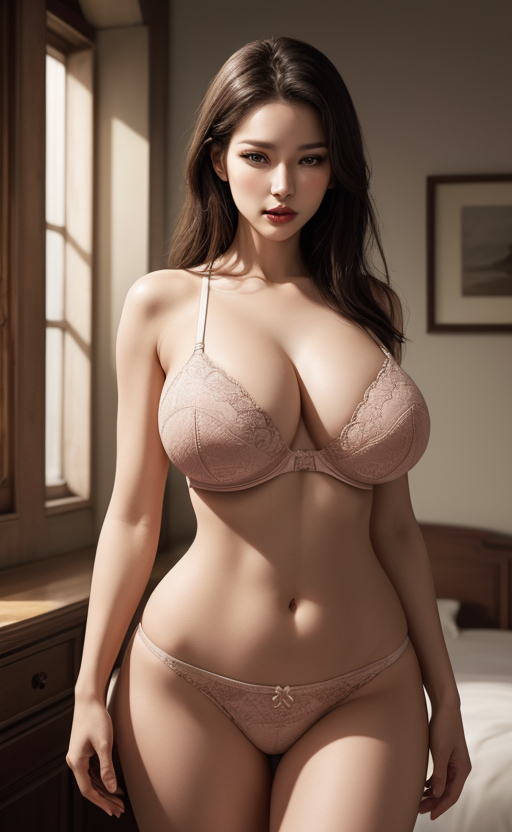

In [13]:
[display(img) for img in imgs];